<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/24_Forecasting_With_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting With A CNN

# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

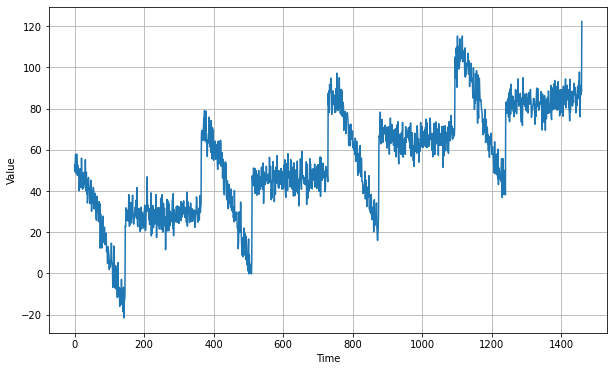

In [0]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Preprocessing With 1D-Convolutional Layers

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, 
                                   batch_size = 128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters = 32, kernel_size = 5, 
                      strides = 1, padding = "causal", 
                      activation = "relu", 
                      input_shape = [None, 1]), 
  keras.layers.LSTM(32, return_sequences = True), 
  keras.layers.LSTM(32, return_sequences = True), 
  keras.layers.Dense(1), 
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = keras.losses.Huber(), 
              optimizer = optimizer, 
              metrics = ["mae"])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 8ms/step - loss: 87.8346 - mae: 88.3341 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 87.1197 - mae: 87.6191 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 85.9241 - mae: 86.4234 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 84.3720 - mae: 84.8713 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 82.4702 - mae: 82.9696 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 80.2434 - mae: 80.7427 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 77.7459 - mae: 78.2453 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 75.0957 - mae: 75.5952 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 72.4508 - mae: 72.9503 - lr: 2.5119e-08
E

(1e-08, 0.0001, 0.0, 30.0)

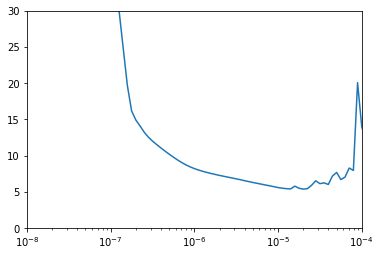

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, 
                                   batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, 
                                   batch_size = 128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters = 32, kernel_size = 5, 
                      strides = 1, padding = "causal", 
                      activation = "relu", 
                      input_shape = [None, 1]), 
  keras.layers.LSTM(32, return_sequences = True), 
  keras.layers.LSTM(32, return_sequences = True), 
  keras.layers.Dense(1), 
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
model.compile(loss = keras.losses.Huber(), 
              optimizer = optimizer, 
              metrics = ["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience = 50)
model.fit(train_set, epochs = 500, 
          validation_data = valid_set, 
          callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 92ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 17ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9232 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 16ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1022 - val_mae: 30.6009
Epoch 4/500
8/8 [==============================] - 0s 16ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 18ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 16ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 0s 17ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 18ms/step - l

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

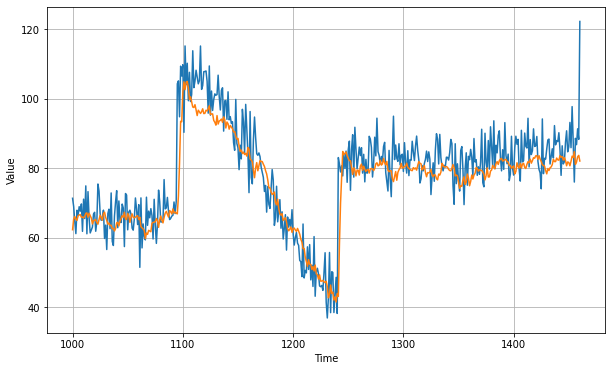

In [0]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.409198

# Fully Convolutional Forecasting

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, 
                                   batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(filters = 32, 
                          kernel_size = 2, 
                          strides = 1, 
                          dilation_rate = dilation_rate, 
                          padding = "causal", 
                          activation = "relu")
  )
  model.add(keras.layers.Conv1D(filters = 1, kernel_size = 1))
  lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-4 * 10**(epoch / 30))
  optimizer = keras.optimizers.Adam(lr = 1e-4)
  model.compile(loss = keras.losses.Huber(), 
                optimizer = optimizer, 
                metrics = ["mae"])
  history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 6ms/step - loss: 66.7702 - mae: 67.2690 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 66.3271 - mae: 66.8258 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 65.8517 - mae: 66.3504 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 65.3352 - mae: 65.8339 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 64.7766 - mae: 65.2753 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 64.1726 - mae: 64.6713 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 63.5116 - mae: 64.0102 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 62.8114 - mae: 63.3100 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 62.0477 - mae: 62.5462 - lr: 1.8478e-04
E

(0.0001, 0.1, 0.0, 30.0)

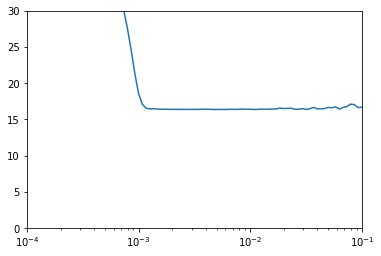

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_Size = 64
train_set = seq2seq_window_dataset(x_train, window_size, 
                                   batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, 
                                   batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(filters = 32, 
                          kernel_size = 2, 
                          strides = 1, 
                          dilation_rate = dilation_rate, 
                          padding = "causal", 
                          activation = "relu")
  )
  model.add(keras.layers.Conv1D(filters = 1, kernel_size = 1))
  optimizer = keras.optimizers.Adam(lr = 3e-4)
  model.compile(loss = keras.losses.Huber(), 
                optimizer = optimizer, 
                metrics = ["mae"])
  
  model_checkpoint = keras.callbacks.ModelCheckpoint(
      "my_checkpoint.h5", save_best_only = True)
  early_stopping = keras.callbacks.EarlyStopping(patience = 50)
  history = model.fit(train_set, epochs = 500, 
                      validation_data = valid_set, 
                      callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 0s 26ms/step - loss: 38.0980 - mae: 38.5962 - val_loss: 70.0887 - val_mae: 70.5887
Epoch 2/500
8/8 [==============================] - 0s 15ms/step - loss: 37.3505 - mae: 37.8485 - val_loss: 68.7147 - val_mae: 69.2147
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 36.6092 - mae: 37.1069 - val_loss: 67.3442 - val_mae: 67.8442
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 35.8635 - mae: 36.3614 - val_loss: 65.9750 - val_mae: 66.4750
Epoch 5/500
8/8 [==============================] - 0s 15ms/step - loss: 35.1168 - mae: 35.6148 - val_loss: 64.6018 - val_mae: 65.1018
Epoch 6/500
8/8 [==============================] - 0s 16ms/step - loss: 34.3677 - mae: 34.8658 - val_loss: 63.2105 - val_mae: 63.7105
Epoch 7/500
8/8 [==============================] - 0s 16ms/step - loss: 33.6063 - mae: 34.1047 - val_loss: 61.8221 - val_mae: 62.3221
Epoch 8/500
8/8 [==============================] - 0s 16ms/ste

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

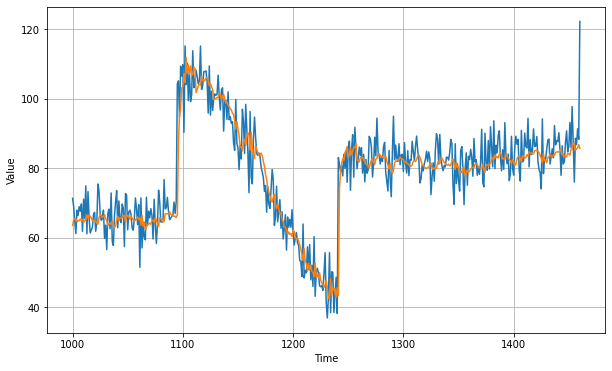

In [0]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5995955